# Aproximación 2: Análisis de Sentimiento con Redes Neuronales LSTM

**Objetivo:** En el ejercicio anterior, vimos las ventajas y limitaciones de un enfoque basado en aprendizaje automático (SVM). Ahora, daremos un gran salto y construiremos un modelo de **Deep Learning** que puede *aprender* el significado y el contexto del texto para clasificar las reseñas.

**¿Por qué este nuevo enfoque?**
A diferencia de nuestro clasificador anterior, una red neuronal puede:
* **Entender el contexto:** Aprende que "not bad" es positivo, mientras que "bad" es negativo.
* **Aprender de los datos:** No necesita listas predefinidas. Descubre los patrones por sí misma a partir de miles de ejemplos.
* **Manejar la semántica:** Aprende que palabras como "excelente" y "maravilloso" son similares en significado.

Empezaremos desde lo más básico para entender cómo funciona esta "magia".

## Fundamentos: ¿Cómo "Piensa" una Red Neuronal?

Para entender una LSTM, necesitamos construir el conocimiento paso a paso.

### 1. ¿Qué es una Red Neuronal? (La Inspiración)
Imagina una red neuronal como un cerebro artificial muy simplificado. Está compuesta por **neuronas** organizadas en **capas**.

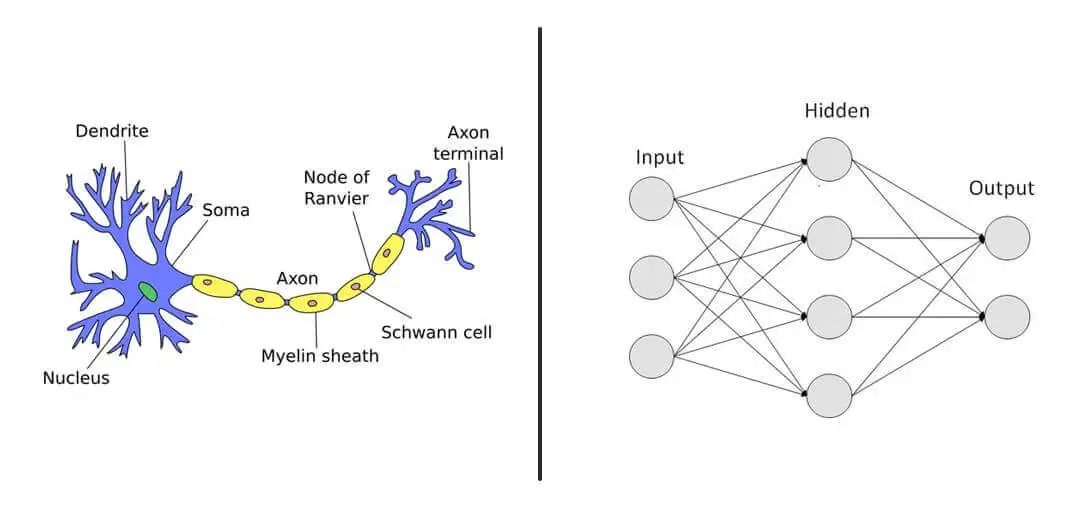

* **Neurona:** Es una pequeña unidad de cálculo. Recibe varias entradas, las procesa (haciendo una suma ponderada) y produce una salida.

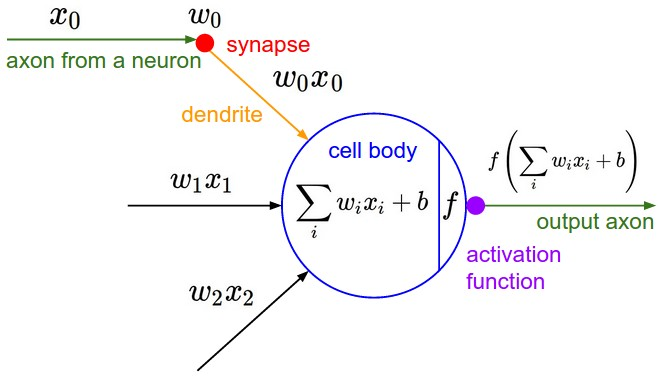


* **Capas:**
    * **Capa de Entrada:** Recibe los datos crudos (por ejemplo, los pixeles de una imagen o, en nuestro caso, los números que representan palabras).
    * **Capas Ocultas:** Son las capas intermedias donde ocurre el "pensamiento". Cada neurona en una capa oculta aprende a detectar patrones específicos. En una imagen, la primera capa podría aprender a detectar bordes, la siguiente a detectar formas (círculos, cuadrados) y la siguiente a detectar objetos (ojos, narices).
    * **Capa de Salida:** Produce el resultado final (ej. "positivo" o "negativo").

El proceso de "aprender" consiste en ajustar las conexiones (o **pesos**) entre las neuronas para que, dados unos datos de entrada, la red produzca la salida correcta.

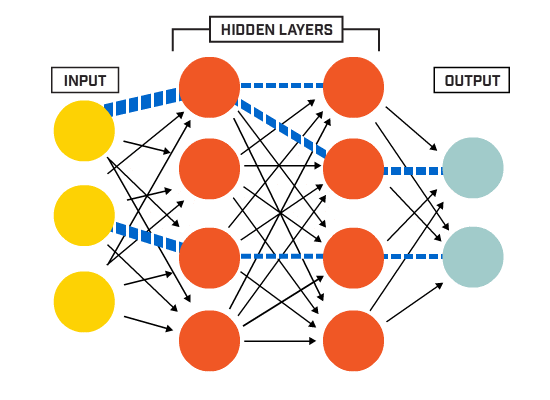


### 2. El Problema del Texto: El Orden Importa
Una red neuronal simple no es buena para procesar texto. ¿Por qué? Porque trata cada palabra de forma aislada. No entiende que la frase "**no me gustó la película**" es muy diferente de "**me gustó la película no**". El orden y la secuencia son cruciales.

### 3. Redes Neuronales Recurrentes (RNN): La Idea de la Memoria
Para resolver el problema del orden, se crearon las **Redes Neuronales Recurrentes (RNN)**. La idea es simple pero poderosa: **tienen un bucle**.

Cuando una RNN procesa una secuencia (como una oración), no solo mira la palabra actual, sino que también recibe información de la palabra que acaba de procesar. Es como leer un libro: para entender la palabra actual, recuerdas las palabras anteriores. Esto le da una forma de **memoria a corto plazo**.

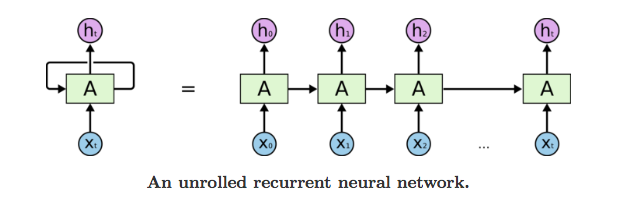

### 4. El Límite de las RNNs: El Olvido a Largo Plazo
Las RNNs simples tienen un problema: su memoria es corta. Si una reseña es muy larga, para cuando la red llega al final, es probable que ya haya "olvidado" las primeras palabras. Esto se conoce como el **problema del gradiente desvaneciente**. Si la palabra clave que define el sentimiento está al principio ("**Excelente** película, aunque el final se alarga un poco..."), una RNN simple podría tener dificultades.

### 5. LSTMs: Memoria a Largo Plazo y "Compuertas"
Aquí es donde entran las **Long Short-Term Memory (LSTM)**. Una LSTM es un tipo avanzado de RNN diseñada específicamente para recordar información durante largos periodos.

¿Cómo lo hace? Mediante un mecanismo ingenioso de **compuertas (gates)**. Piensa en una LSTM como un trabajador muy organizado con una cinta transportadora (el "estado de la celda" o memoria a largo plazo) y tres supervisores (las compuertas):
1.  **Compuerta de Olvido (Forget Gate):** Decide qué información de la memoria a largo plazo ya no es relevante y debe ser desechada. (Ej: "Al empezar la película, el logo del estudio era bonito, pero..." -> el logo no es importante para el sentimiento, así que lo olvida).
2.  **Compuerta de Entrada (Input Gate):** Decide qué información nueva de la palabra actual es lo suficientemente importante como para guardarla en la memoria a largo plazo. (Ej: "la actuación fue **terrible**" -> "terrible" es muy importante, ¡hay que guardarlo!).
3.  **Compuerta de Salida (Output Gate):** Decide qué parte de la memoria a largo plazo se usará para generar la salida en este paso.

Este sistema de compuertas permite a la LSTM mantener un control preciso sobre su memoria, recordando lo crucial y olvidando lo irrelevante a lo largo de secuencias muy largas.

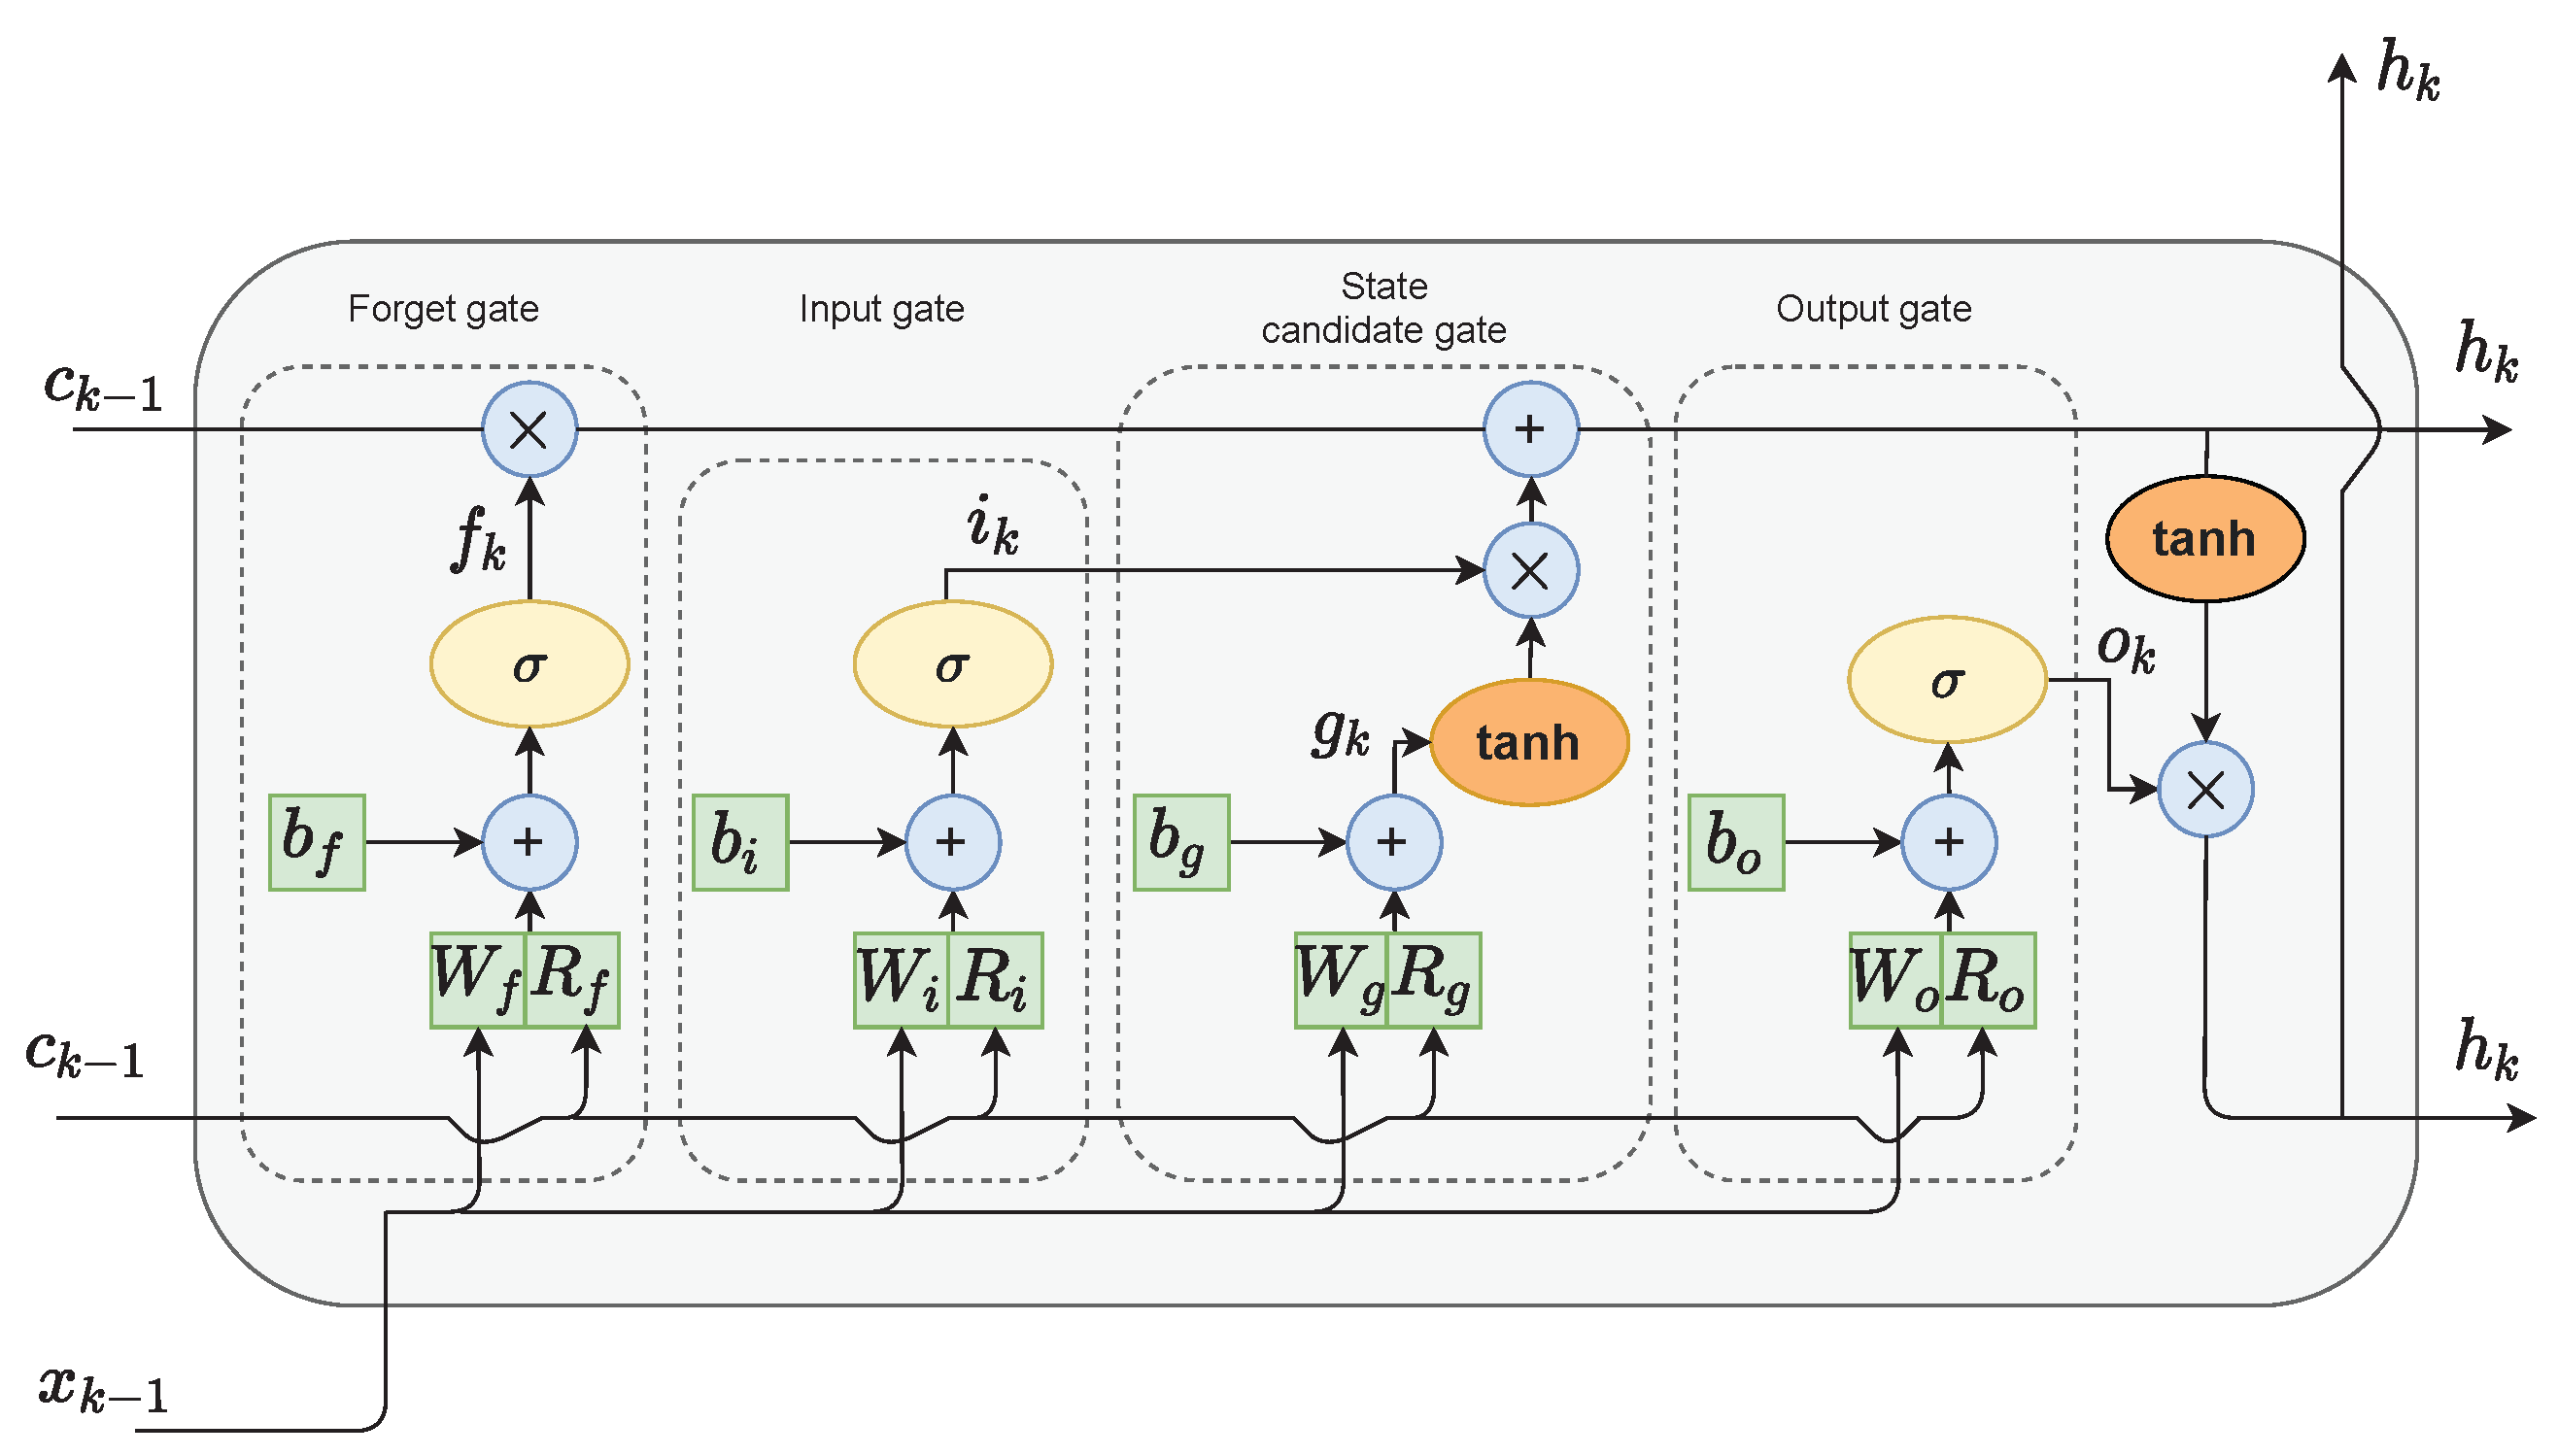



Ahora, ¡vamos a construir una!

In [ ]:
# --- Paso 1: Instalaciones y Autenticación de Kaggle ---
!pip install kaggle -q
from google.colab import files
import os

# Solo necesitas subir tu kaggle.json si no lo has hecho en esta sesión
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Por favor, sube tu archivo 'kaggle.json':")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\n Autenticación de Kaggle completada.")

# --- Paso 2: Descargar y Descomprimir ---
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -q
!unzip -q imdb-dataset-of-50k-movie-reviews.zip

# --- Paso 3: Cargar y Preparar Datos ---
import pandas as pd
df = pd.read_csv('IMDB Dataset.csv')

# Convertimos las etiquetas a números (0 para negativo, 1 para positivo)
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

print(f"Dataset cargado con {len(df)} reseñas.")
print(df.head())

Por favor, sube tu archivo 'kaggle.json':


Saving kaggle.json to kaggle.json

 Autenticación de Kaggle completada.
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
Dataset cargado con 50000 reseñas.
                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


# Pre-procesamiento de Texto: Traduciendo Palabras a Números para la Red Neuronal

Como mencionamos, las redes neuronales son increíblemente poderosas, pero tienen una limitación fundamental: no entienden palabras, solo entienden números. Operan a través de matemáticas, por lo que nuestro primer y más crucial paso es convertir las reseñas de texto en un formato numérico que el modelo LSTM pueda procesar.

Este bloque de código se encarga exactamente de esa traducción.

* `numpy:` Es la biblioteca fundamental para computación numérica en Python. La usaremos para manejar nuestros arreglos de datos de manera eficiente.

* ` Tokenizer:` Es una herramienta de Keras (TensorFlow) que funciona como nuestro "constructor de diccionarios". Su trabajo es analizar todo el texto y asignar un número entero único a cada palabra.

* `pad_sequences: `También de Keras, esta función nos ayuda a que todas nuestras reseñas tengan exactamente la misma longitud, rellenando las más cortas y cortando las más largas.

* ` train_test_split:` Una utilidad de la popular biblioteca Scikit-learn. Su función es barajar y dividir nuestros datos en dos conjuntos: uno para entrenar el modelo y otro para probar qué tan bien aprendió.

In [ ]:
# Las redes neuronales no entienden palabras, entienden números.
# Este paso es CRUCIAL y convierte el texto en un formato que la red pueda procesar.

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Definición de los Parámetros Clave (Hiperparámetros)
Antes de procesar, definimos algunas reglas importantes que guiarán la transformación. Estos se conocen como hiperparámetros, porque son configuraciones que nosotros, los programadores, elegimos antes de que el modelo comience a aprender.

* `VOCAB_SIZE = 10000: `Tamaño del Vocabulario. En un dataset tan grande, hay decenas de miles de palabras únicas. Usarlas todas sería computacionalmente muy costoso y muchas de ellas son raras (aparecen una o dos veces). Por eso, le decimos al modelo que solo considere las 10,000 palabras más frecuentes. Esto nos da un buen balance entre tener suficiente vocabulario y mantener el modelo manejable.

* `MAX_LENGTH = 150:` Longitud Máxima. Las redes neuronales necesitan que todas sus entradas tengan el mismo tamaño. Aquí, establecemos que cada reseña tendrá una longitud de 150 palabras. Si una reseña es más larga, se cortará. Si es más corta, se rellenará con ceros.

* `EMBEDDING_DIM = 32:` Dimensión del Embedding. Este es un concepto avanzado que veremos en la capa del modelo, pero en resumen: en lugar de que cada palabra sea solo un número (como "película" = 5), se convertirá en un vector (una lista) de 32 números. Esto permite que el modelo aprenda relaciones complejas entre palabras. Por ejemplo, podría aprender que los vectores de "genial" y "fantástico" son muy similares.

In [ ]:
# --- Parámetros de Pre-procesamiento ---
VOCAB_SIZE = 10000  # Número máximo de palabras a considerar en nuestro vocabulario
MAX_LENGTH = 150    # Longitud máxima de cada reseña (las más largas se cortan, las más cortas se rellenan)
EMBEDDING_DIM = 32  # Dimensión de los vectores de palabras (embeddings)

# Tokenización: El Diccionario Digital
Aquí es donde convertimos las palabras en números.

* `tokenizer = Tokenizer(...):` Creamos nuestro "diccionario".

  * `num_words=VOCAB_SIZE: `Le indicamos que solo se preocupe por las 10,000 palabras más comunes.

  * `oov_token="<OOV>":` Esto es muy importante. "OOV" significa Out Of Vocabulary (Fuera de Vocabulario). Si el modelo encuentra una palabra que no está en su diccionario de 10,000, le asignará este token especial en lugar de dar un error.

* `tokenizer.fit_on_texts(df['review']): `El tokenizer "lee" todas las reseñas para construir su diccionario interno (word_index), donde asigna un número a cada palabra (ej: {'the': 1, 'a': 2, 'movie': 3, ...}).

* `sequences = tokenizer.texts_to_sequences(df['review']):` Ahora que el diccionario está listo, esta línea "traduce" cada reseña de texto a su secuencia correspondiente de números.

* Ejemplo:
  *   Texto Original: `"This movie is great"`
  *   Secuencia Convertida: `[10, 18, 5, 128]` (los números son ilustrativos)


In [ ]:
# --- Tokenización ---
# Convierte cada palabra en un número entero único.
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>") # <OOV> es para palabras fuera del vocabulario
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])

# Padding (Relleno): Estandarizando la Longitud
Como las reseñas tienen diferentes longitudes, necesitamos estandarizarlas a 150 palabras.

* `pad_sequences(sequences, ...):` Esta función toma nuestras secuencias de números y las ajusta.

  * `maxlen=MAX_LENGTH: `El objetivo es que cada secuencia mida 150.

  * `padding='post':` Si una reseña es más corta de 150, se añadirán ceros al final (post) para rellenarla.

  * ` truncating='post':` Si una reseña es más larga de 150, se eliminarán palabras del final (post).

* Ejemplo (con MAX_LENGTH = 10):

  * Secuencia Original: `[10, 18, 5, 128]` (longitud 4)

  * Después del Padding: `[10, 18, 5, 128, 0, 0, 0, 0, 0, 0]` (longitud 10)

In [ ]:
# --- Padding ---
# Asegura que todas las secuencias (reseñas) tengan la misma longitud.
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, truncating='post', padding='post')


In [ ]:
# --- Preparar Datos Finales ---
X = padded_sequences
y = df['sentiment'].values

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Forma de los datos de entrenamiento (X_train): {X_train.shape}")
print(f"Forma de las etiquetas de entrenamiento (y_train): {y_train.shape}")

Forma de los datos de entrenamiento (X_train): (40000, 150)
Forma de las etiquetas de entrenamiento (y_train): (40000,)


# ¿Qué es Keras y para que lo usamos?
Keras es una biblioteca de software de código abierto que se utiliza para construir y entrenar redes neuronales. Fue creada por François Chollet, un ingeniero de Google, y lanzada en 2015. Su principal objetivo es hacer que la creación de modelos de aprendizaje profundo sea más fácil y rápida, permitiendo a los desarrolladores experimentar con diferentes arquitecturas de redes neuronales de manera sencilla.

Usamos Keras en este Colab para:

* **Construir el modelo LSTM:** Keras nos proporciona las herramientas para definir las capas de nuestra red neuronal (Embedding, LSTM, Dense) de una manera muy intuitiva.

* **Compilar el modelo:** Nos permite configurar cómo se entrenará el modelo, especificando el optimizador, la función de pérdida y las métricas que queremos utilizar.

* **Entrenar y evaluar el modelo:** Con solo unas pocas líneas de código, podemos entrenar nuestro modelo con los datos de IMDb y evaluar su rendimiento en el conjunto de prueba.

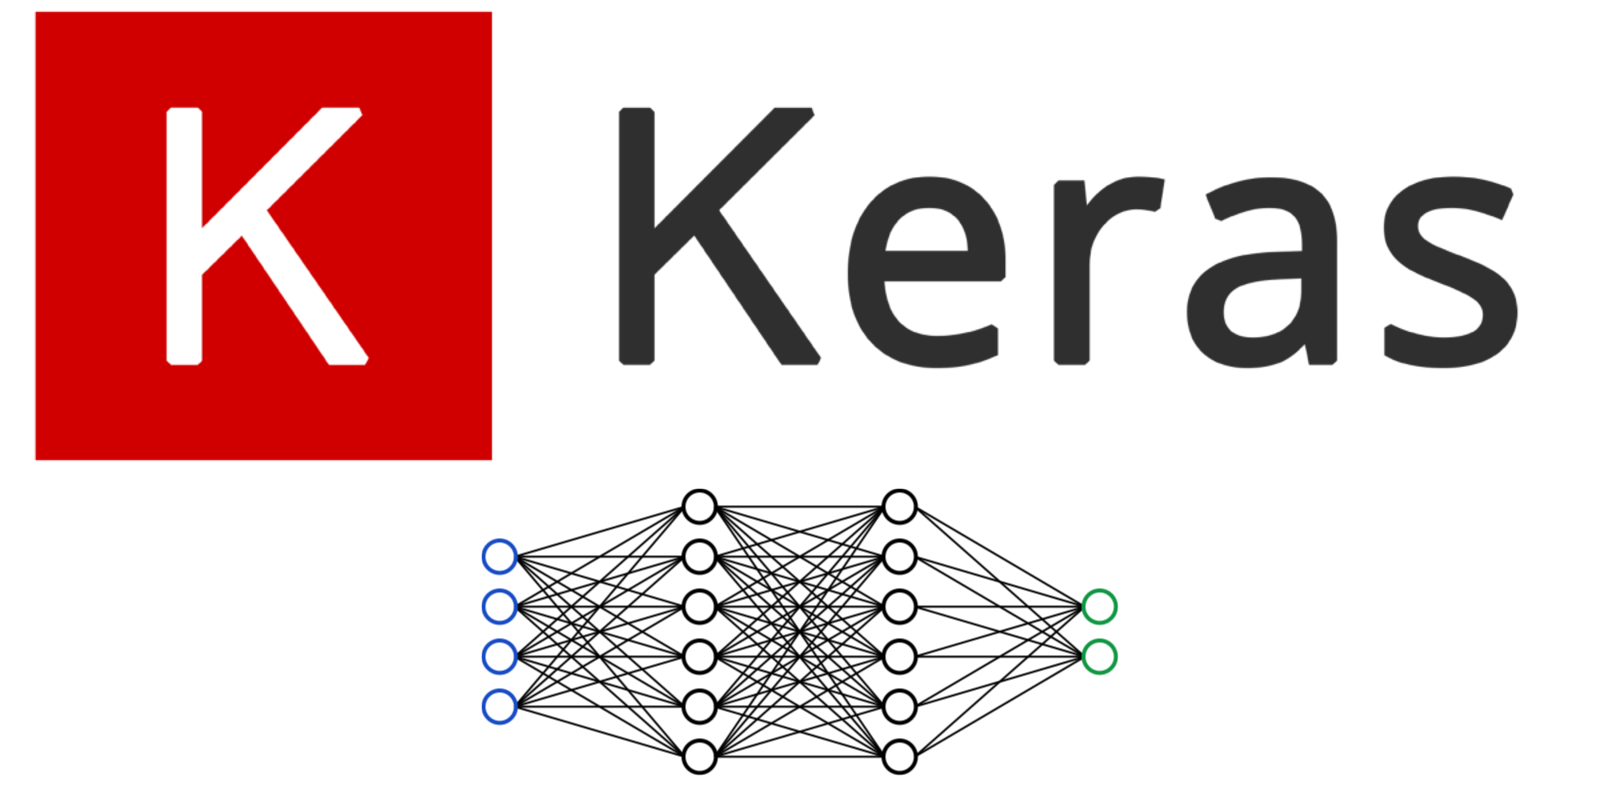

## Armando el Cerebro de Nuestra Red: El Modelo `Sequential` de Keras

Ahora que nuestros datos están en un formato numérico que la red puede entender, es hora de construir el "cerebro" que aprenderá a clasificar las reseñas. Para esto, usamos `tf.keras.Sequential`.

Piensa en un modelo `Sequential` como una pila de bloques de Lego. Cada "bloque" es una **capa** de la red neuronal, y las apilamos una encima de la otra. Los datos entrarán por la primera capa, pasarán a la siguiente, y así sucesivamente, hasta que la última capa nos dé el resultado final.

Nuestro modelo tiene tres capas apiladas: `Embedding`, `LSTM` y `Dense`.

-----

### Paso 1: La Capa de Embedding (El Traductor Inteligente)

Esta es la primera y una de las capas más importantes para el Procesamiento del Lenguaje Natural. Su trabajo es tomar los números enteros (que representan palabras) y convertirlos en **vectores densos** o **"embeddings"**.

Imagina que en lugar de que la palabra "película" sea solo el número `5`, ahora será representada por una lista (vector) de 32 números, algo como `[0.2, -0.4, 0.7, ..., -0.1]`.

  * `input_dim=VOCAB_SIZE`: Le dice a la capa cuántas palabras únicas hay en nuestro vocabulario (10,000). Necesita saber esto para crear un vector para cada palabra.
  * `output_dim=EMBEDDING_DIM`: Define el tamaño de cada vector de palabra. En nuestro caso, cada palabra se representará con un vector de 32 números.
  * `input_length=MAX_LENGTH`: Especifica que cada reseña que entre a esta capa tendrá una longitud de 150 números.

Lo más poderoso de esta capa es que **aprende durante el entrenamiento**. Inicialmente, los vectores son aleatorios, pero a medida que el modelo se entrena, ajusta estos vectores para que palabras con significados similares (como "genial" y "fantástico") terminen teniendo vectores muy parecidos. Esto permite al modelo entender la **relación semántica** entre las palabras.

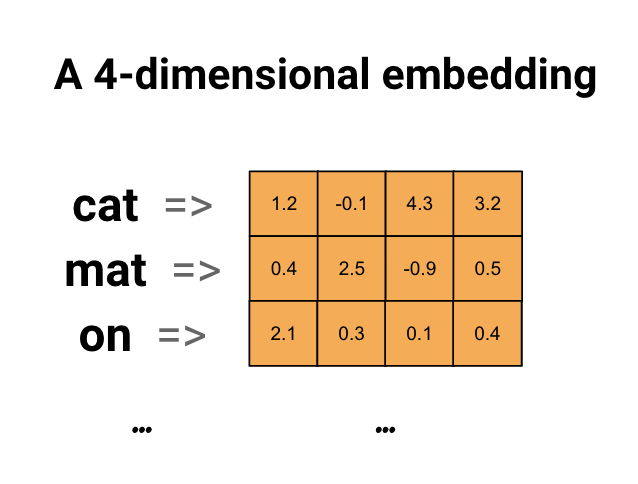
-----

### Paso 2: La Capa LSTM (El Lector con Memoria)

Esta es el corazón de nuestro modelo. La capa `LSTM` toma como entrada la secuencia de vectores de palabras que produjo la capa de Embedding y la procesa en orden, utilizando su **memoria interna** para entender el contexto.

  * `LSTM(64)`: El número `64` se refiere a la cantidad de **unidades** o "neuronas" dentro de la capa LSTM. Este número define la "capacidad de memoria" de la capa. Un número más alto le permite recordar patrones más complejos, pero también hace que el modelo sea más pesado.

La capa LSTM leerá la secuencia de 150 vectores de palabras y, gracias a sus compuertas (olvido, entrada y salida), generará un **único vector de salida** que resume el significado y el sentimiento de toda la reseña.

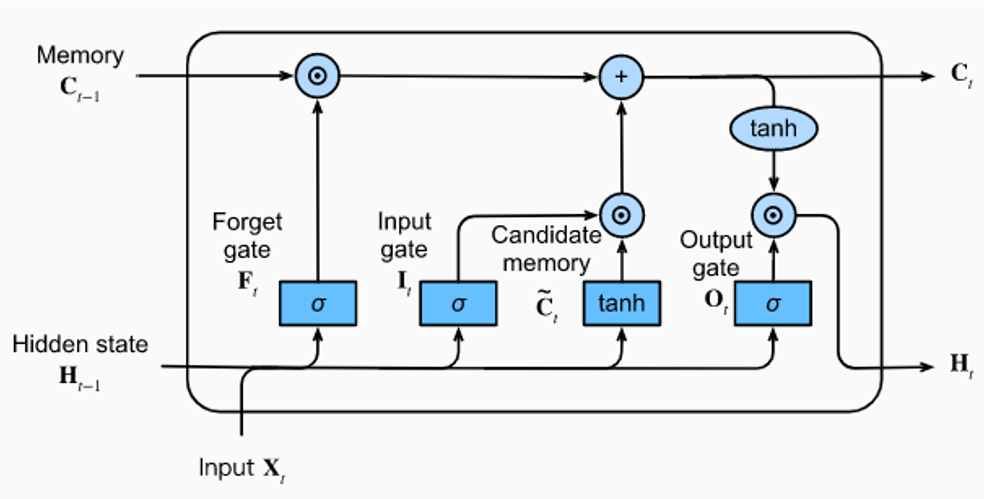
-----

### Paso 3: La Capa Densa de Salida (El Juez Final)

Esta es la última capa de nuestra pila. Su trabajo es tomar el vector resumen que le entrega la LSTM y tomar la decisión final: ¿la reseña es positiva o negativa?

  * `Dense(1, ...)`: Le decimos que esta capa tendrá **una sola neurona**.
  * `activation='sigmoid'`: Esta es la clave. La **función de activación sigmoide** es una función matemática que toma cualquier número y lo transforma en un valor **entre 0 y 1**.

Este resultado es perfecto para nuestro problema:

  * Si la salida de la neurona es un número cercano a **0**, lo interpretaremos como un sentimiento **negativo**.
  * Si la salida es cercana a **1**, lo interpretaremos como un sentimiento **positivo**.

### Resumen del Flujo de Datos en el Modelo:

1.  **Entrada:** Una reseña como una secuencia de 150 números (ej: `[10, 18, ..., 95]`).
2.  **Capa Embedding:** Transforma la secuencia de números en una secuencia de 150 vectores, donde cada vector tiene 32 dimensiones.
3.  **Capa LSTM:** Procesa la secuencia de vectores y la condensa en un único vector resumen de 64 dimensiones.
4.  **Capa Densa:** Toma el vector resumen y produce la predicción final: un solo número entre 0 y 1.

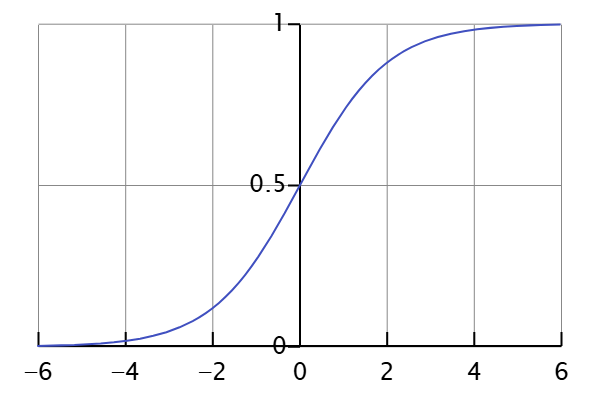

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    # 1. Capa de Embedding: Convierte los números (palabras) en vectores densos.
    # Aprende las relaciones semánticas entre palabras.
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),

    # 2. Capa LSTM: Procesará la secuencia de vectores de palabras.
    # 64 es el número de unidades en la LSTM (la dimensionalidad de su memoria).
    tf.keras.layers.LSTM(64),

    # 3. Capa Densa de Salida: Una neurona final con activación sigmoide.
    # El sigmoide da una salida entre 0 y 1, perfecto para clasificación binaria (negativo/positivo).
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Compilación del Modelo

La compilación es un paso fundamental en el flujo de trabajo de aprendizaje profundo. Es la fase en la que se configura el modelo para el entrenamiento, definiendo la función de pérdida, el optimizador y las métricas de rendimiento. Este proceso es comparable a la configuración de un experimento científico, donde se establecen los parámetros y las herramientas de medición antes de iniciar la observación.

* **`loss='binary_crossentropy'`**: La **función de pérdida** (o función de costo) cuantifica la discrepancia entre las predicciones del modelo y las etiquetas reales. En este caso, **`binary_crossentropy`** es la elección estándar para problemas de **clasificación binaria**, donde la salida del modelo se reduce a dos clases mutuamente excluyentes (por ejemplo, 0 o 1, verdadero o falso). El objetivo del entrenamiento es **minimizar** esta función.
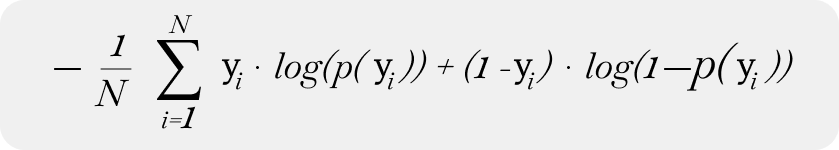


* **`optimizer='adam'`**: El **optimizador** es el algoritmo responsable de ajustar los **pesos** del modelo durante el entrenamiento para reducir la función de pérdida. **Adam** (Adaptive Moment Estimation) es un algoritmo de optimización de gradiente descendente que destaca por su eficiencia y robustez. Se adapta a la tasa de aprendizaje de cada parámetro individualmente, lo que acelera la convergencia y mejora el rendimiento general del modelo.

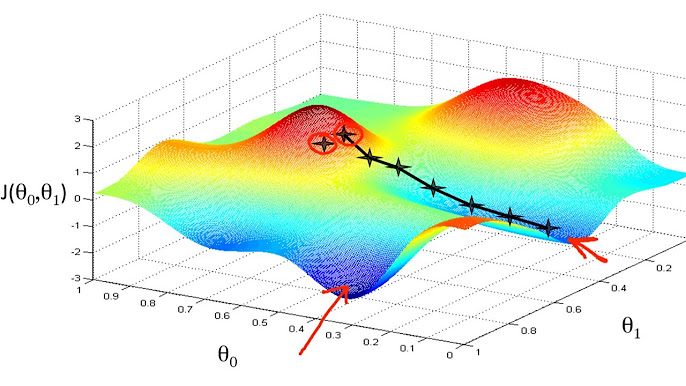

* **`metrics=['accuracy']`**: Las **métricas** son utilizadas para evaluar el rendimiento del modelo. La **precisión** (`accuracy`) mide la proporción de predicciones correctas sobre el total de predicciones. Esta métrica es especialmente útil para monitorear el progreso del entrenamiento y para la evaluación posterior del modelo.

In [ ]:
# Compilamos el modelo
model.compile(
    loss='binary_crossentropy', # Función de pérdida para clasificación binaria
    optimizer='adam',             # Un optimizador eficiente y popular
    metrics=['accuracy']          # Métrica para monitorear durante el entrenamiento
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del Modelo
El proceso de entrenamiento, iniciado con model.fit(), es donde el modelo aprende a partir de los datos. Piensa en esto como un estudiante que revisa material de estudio.

* `NUM_EPOCHS = 5:` Una época es un ciclo completo en el que el modelo ve todos los datos de entrenamiento. En este caso, el modelo pasará por todo el conjunto de datos de entrenamiento cinco veces. Más épocas pueden mejorar el rendimiento, pero también aumentan el riesgo de sobreajuste (cuando el modelo aprende demasiado los datos de entrenamiento y no generaliza bien a datos nuevos).

* `BATCH_SIZE = 64:` El tamaño del lote define la cantidad de muestras de entrenamiento que se procesan antes de que los parámetros del modelo se actualicen. En lugar de actualizar los pesos después de cada muestra (lo cual es ineficiente), el modelo agrupa los datos en lotes de 64. Esto hace que el entrenamiento sea más rápido y estable.

# Proceso de Entrenamiento y Métricas de Rendimiento

La salida del entrenamiento muestra el progreso por época. Cada línea representa una época y te da una idea de cómo el modelo mejora (o no) con el tiempo.

* `accuracy`: La precisión en los datos de entrenamiento. Como se puede ver, este valor aumenta en cada época, lo que indica que el modelo está aprendiendo.

* `loss`: La pérdida en los datos de entrenamiento. A medida que la precisión aumenta, la pérdida disminuye, lo que significa que el modelo está cometiendo menos errores.

* `val_accuracy`: La precisión en los datos de validación (X_test, y_test). Esto es crucial porque nos dice qué tan bien está el modelo generalizando a datos que no ha visto antes.

* `val_loss:` La pérdida en los datos de validación. Es una señal de alerta si esta pérdida empieza a aumentar, ya que podría indicar un sobreajuste.

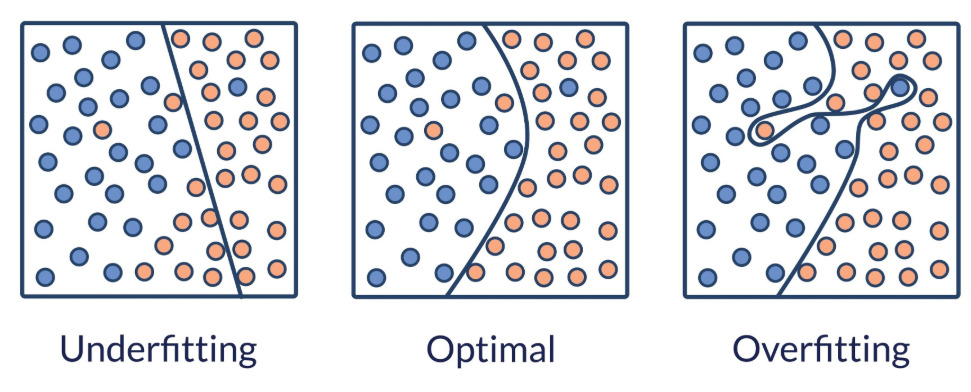

# Evaluación Final del Modelo

Después del entrenamiento, se evalúa el modelo final con el conjunto de prueba para obtener un resultado imparcial del rendimiento.

* model.evaluate(): Esta función mide la precisión y la pérdida del modelo en un conjunto de datos específico. En este caso, el conjunto de prueba, que el modelo no ha visto durante el entrenamiento.

* Pérdida (Loss) en el conjunto de prueba: Es el valor final de la función de pérdida. Un valor más bajo indica un mejor rendimiento.

* Precisión (Accuracy) en el conjunto de prueba: La métrica final de rendimiento del modelo. El 85.47% significa que el modelo clasificó correctamente el 85.47% de las muestras en el conjunto de prueba.

* Esta evaluación final es la métrica más importante para juzgar el rendimiento de tu modelo en escenarios del mundo real.

In [ ]:
# ¡Ahora entrenamos el modelo con nuestros datos!
NUM_EPOCHS = 5
BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test)
)

# Evaluamos el modelo final con el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)

print("\n" + "="*30)
print("RESULTADOS FINALES")
print("="*30)
print(f"Pérdida (Loss) en el conjunto de prueba: {loss:.4f}")
print(f"Precisión (Accuracy) en el conjunto de prueba: {accuracy:.2%}")

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5392 - loss: 0.6818 - val_accuracy: 0.5500 - val_loss: 0.6779
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6603 - loss: 0.6205 - val_accuracy: 0.8219 - val_loss: 0.4200
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8234 - loss: 0.4238 - val_accuracy: 0.8241 - val_loss: 0.4342
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8358 - loss: 0.4051 - val_accuracy: 0.7426 - val_loss: 0.5225
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7319 - loss: 0.5284 - val_accuracy: 0.8244 - val_loss: 0.4041
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8234 - loss: 0.4024

RESULTADOS FINALES
Pérdida (Loss) en el conjunto de prueba: 0.4041
Precisión (Accuracy) en el conjunto de prueba: 82.44%


### Resumen de la Arquitectura del Modelo
Esta tabla es un resumen (`model.summary()`) que muestra la arquitectura de una red neuronal secuencial, comúnmente utilizada para el procesamiento de texto. Muestra cada capa en orden, su forma de salida y el número de parámetros que contiene.

---

### Análisis Capa por Capa

1.  **Capa de `embedding` (Embedding)**: Esta es la primera capa y convierte los datos de entrada de texto (que son índices numéricos) en vectores densos y de tamaño fijo.
    * **`Output Shape`**: `(64, 150, 32)`
        * `64`: Corresponde al `batch_size`, es decir, el número de oraciones procesadas simultáneamente.
        * `150`: Es el **`input_length`** o la longitud máxima de la secuencia (número de palabras por oración).
        * `32`: Es la dimensión de cada vector de incrustación (`embedding_dim`), o el número de características que representan cada palabra.
    * **`Param #`**: `320,000`
        * Estos parámetros se calculan como `vocab_size` (tamaño del vocabulario) multiplicado por `embedding_dim`. Esto significa que el modelo está aprendiendo un vector de 32 dimensiones para cada una de las 10,000 palabras en el vocabulario (`10,000 * 32 = 320,000`).

2.  **Capa `lstm` (LSTM)**: Esta es una capa recurrente que procesa las secuencias de datos (los vectores de palabras de la capa anterior). Las celdas LSTM son especialmente buenas para capturar dependencias a largo plazo en los datos secuenciales, lo que las hace ideales para tareas de procesamiento de lenguaje natural (NLP).
    * **`Output Shape`**: `(64, 64)`
        * `64`: Es de nuevo el tamaño del lote.
        * `64`: Corresponde al número de unidades en la capa LSTM. Este es el tamaño del vector de salida o el estado oculto que la capa produce para cada secuencia.
    * **`Param #`**: `24,832`
        * Los parámetros de una celda LSTM son más complejos, ya que involucran pesos para las compuertas de olvido, entrada, salida y para la celda de memoria. La fórmula para su cálculo es `4 * ((num_unidades_ocultas + num_características_de_entrada) * num_unidades_ocultas + num_unidades_ocultas)`. Aquí, `num_características_de_entrada` es 32 (la `embedding_dim`).
        * `4 * ((64 + 32) * 64 + 64) = 24,832`.

3.  **Capa `dense` (Dense)**: Esta es la capa de salida. Es una capa neuronal completamente conectada que toma la salida de la capa LSTM y la usa para hacer la predicción final (en este caso, una clasificación binaria).
    * **`Output Shape`**: `(64, 1)`
        * `64`: El tamaño del lote.
        * `1`: El número de unidades en la capa densa. Como es un problema de clasificación binaria, solo necesitamos una neurona para producir la probabilidad de la clase positiva.
    * **`Param #`**: `65`
        * Los parámetros se calculan como `(número_de_unidades_de_entrada * número_de_unidades_de_salida) + número_de_unidades_de_salida` (el sesgo o *bias*).
        * `(64 * 1) + 1 = 65`.

---

### Resumen Final de Parámetros

* **`Total params`**: La suma de todos los parámetros en todas las capas. Este es el tamaño total del modelo en términos de parámetros.
* **`Trainable params`**: Los parámetros que se ajustarán durante el entrenamiento (es decir, los pesos y sesgos de las capas). En este caso, todas las capas son entrenables.
* **`Non-trainable params`**: Parámetros que no se ajustan durante el entrenamiento (ej. si se usan pesos pre-entrenados, como con *GloVe*). En este modelo, este valor es 0.
* **`Optimizer params`**: Parámetros internos del optimizador (como Adam) que se usan para el entrenamiento pero no son parte del modelo final.

Comprender esta tabla es crucial para depurar y optimizar arquitecturas de redes neuronales, ya que te ayuda a identificar la complejidad del modelo y a detectar posibles errores en las dimensiones de las capas.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 150, 32)          │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 64)               │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,034,693 (3.95 MB)

 Trainable params: 344,897 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 689,796 (2.63 MB)

## Conclusión: El Poder del Aprendizaje

Notarás que la precisión del modelo LSTM (probablemente **superior al 85%**) es significativamente más alta que la de nuestro enfoque con regex (que rondaba el 65-70%).

**¿Por qué es mucho mejor?**

1.  **Contexto:** La LSTM procesó las palabras en orden, aprendiendo patrones secuenciales. "not" seguido de "bad" fue aprendido como un patrón positivo.
2.  **Representación Semántica (Embeddings):** La capa de Embedding aprendió que palabras como "great", "fantastic" y "amazing" son similares y deben tratarse de manera parecida, algo que nuestro léxico manual no podía hacer.
3.  **Generalización:** El modelo no solo memorizó, sino que aprendió a generalizar a partir de los datos de entrenamiento para hacer predicciones precisas en reseñas que nunca antes había visto.

Este ejercicio demuestra el poder del Deep Learning para tareas de NLP. A partir de aquí, se abren las puertas a arquitecturas aún más avanzadas como LSTMs Bidireccionales, GRUs, y los revolucionarios Transformers.